# Fashion-MNIST CNN with PyTorch

This notebook mirrors the training script while keeping the workflow interactive for experimentation.


## Imports

Import PyTorch, Torchvision, and plotting utilities needed for data handling, model building, and visualization.


In [ ]:
import os  # filesystem utilities for saving artifacts
from typing import Tuple  # type hint for dataloader return values

import matplotlib.pyplot as plt  # plotting for visualizations and diagnostics
import torch  # core PyTorch package
import torch.nn as nn  # neural network layers and modules
import torch.optim as optim  # optimization algorithms (Adam, SGD, etc.)
from torch.utils.data import DataLoader  # efficient batching utilities
from torchvision import datasets, transforms  # dataset loaders and image transforms



## Configuration

Define label names, training hyperparameters, and determine the compute device.


In [ ]:
LABEL_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]  # human-readable class names for reporting

SEED = 42  # reproducibility seed for weight initialization and shuffling
BATCH_SIZE = 128  # number of images per training batch
EPOCHS = 10  # total passes through the dataset
LEARNING_RATE = 1e-3  # step size for optimizer updates
WEIGHT_DECAY = 1e-4  # L2 regularization strength
NUM_WORKERS = 2  # parallel workers for data loading
DATA_DIR = "data"  # location where datasets will be stored
SAVE_DIR = "artifacts"  # directory for checkpoints and plots

os.makedirs(SAVE_DIR, exist_ok=True)  # ensure artifact directory exists before saving

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # prefer GPU when available
print(f"Using device: {device}")

torch.manual_seed(SEED)  # set seed for CPU operations
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)  # set seed for all GPU devices


Using device: cpu


## Data Loading

Download Fashion-MNIST, set up preprocessing transforms, and create train/test dataloaders.


In [ ]:
def get_dataloaders(
    data_dir: str,
    batch_size: int,
    num_workers: int,
) -> Tuple[DataLoader, DataLoader]:
    """Create training and test dataloaders with preprocessing transforms."""
    transform = transforms.Compose(
        [
            transforms.ToTensor(),  # convert PIL image to tensor scaled to [0, 1]
            transforms.Normalize((0.2860,), (0.3530,)),  # normalize using Fashion-MNIST stats
        ]
    )

    train_dataset = datasets.FashionMNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=transform,
    )  # download/load training split with preprocessing
    test_dataset = datasets.FashionMNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=transform,
    )  # download/load test split with the same preprocessing

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )  # shuffle batches for SGD stability
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )  # deterministic order for evaluation

    return train_loader, test_loader


train_loader, test_loader = get_dataloaders(DATA_DIR, BATCH_SIZE, NUM_WORKERS)  # instantiate loaders and trigger download if needed
len(train_loader.dataset), len(test_loader.dataset)  # report dataset sizes for sanity check


100%|██████████| 26.4M/26.4M [00:27<00:00, 955kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 245kB/s]
100%|██████████| 4.42M/4.42M [00:13<00:00, 323kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.3MB/s]


(60000, 10000)

## Sample Visualization

Preview a small batch of training images with their labels to verify inputs.


c:\Users\syeda\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


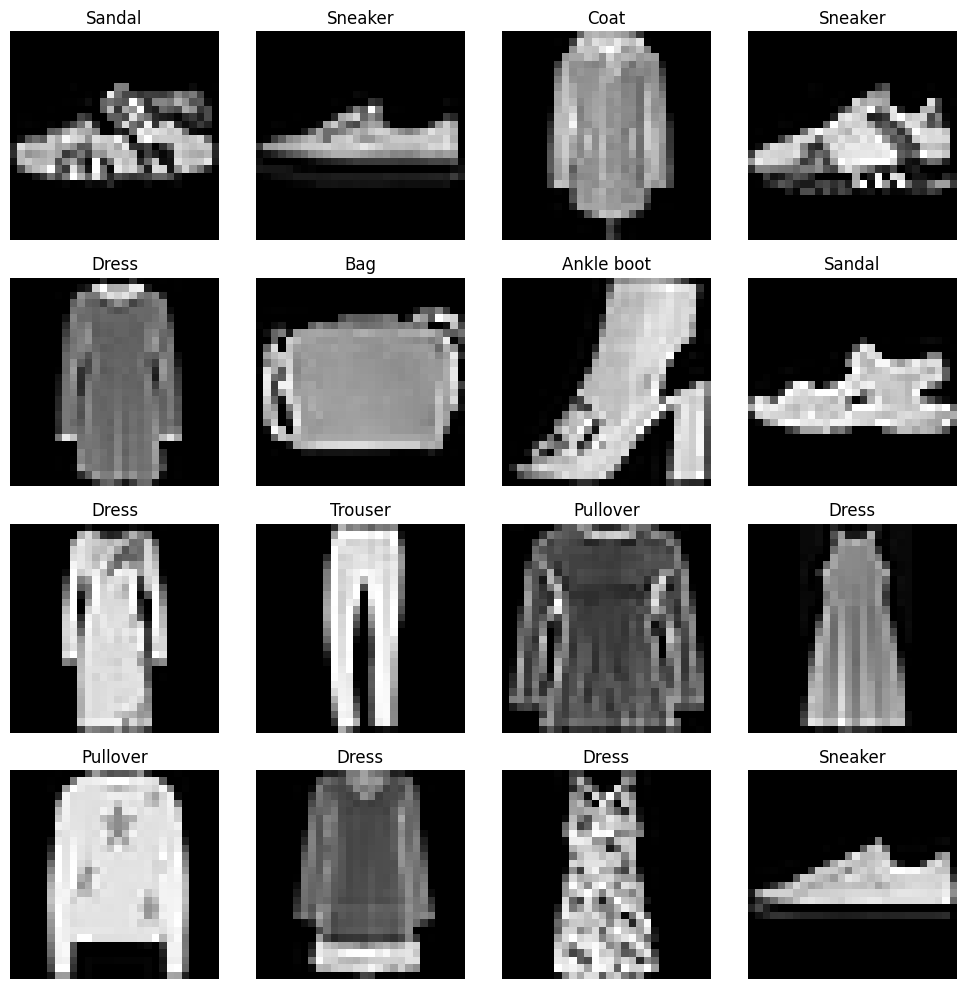

In [ ]:
def show_batch(dataloader: DataLoader, n_images: int = 16) -> None:
    """Visualize a small batch of images and labels."""
    images, labels = next(iter(dataloader))  # grab a single batch from the dataloader iterator
    images, labels = images[:n_images], labels[:n_images]  # limit to the requested number of images

    cols = 4  # number of columns in the visualization grid
    rows = (n_images + cols - 1) // cols  # compute row count to fit all images
    plt.figure(figsize=(2.5 * cols, 2.5 * rows))  # size the figure proportional to grid dimensions
    for idx, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(rows, cols, idx + 1)  # select subplot position
        plt.imshow(img.squeeze(0), cmap="gray")  # display grayscale image (remove channel dim)
        plt.title(LABEL_NAMES[label])  # annotate with human-readable label
        plt.axis("off")  # hide axes for a cleaner look
    plt.tight_layout()  # reduce whitespace between subplots
    plt.show()  # render the figure


show_batch(train_loader)  # preview a batch of preprocessed training images


## Baseline: Fully Connected Network

Start with a simple multilayer perceptron (MLP) that treats each image as a flat vector to establish a baseline accuracy.


In [ ]:
class FashionMLP(nn.Module):
    """Two-layer fully connected baseline model."""

    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),  # reshape 28x28 image into 784-length vector
            nn.Linear(28 * 28, 256),  # first dense layer
            nn.ReLU(),  # non-linear activation
            nn.Dropout(0.2),  # regularization to prevent overfitting
            nn.Linear(256, 128),  # second dense layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10),  # logits for the 10 classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


mlp = FashionMLP().to(device)  # instantiate baseline model on selected device
mlp_criterion = nn.CrossEntropyLoss()  # standard loss for multi-class classification
mlp_optimizer = optim.Adam(mlp.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # optimizer for MLP
mlp


FashionMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
mlp_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}  # track metrics per epoch
mlp_best_acc = 0.0  # keep best validation accuracy encountered

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(mlp, train_loader, mlp_criterion, mlp_optimizer, device)  # training step
    val_loss, val_acc, _ = evaluate(mlp, test_loader, mlp_criterion, device)  # validation pass on test split

    mlp_history["train_loss"].append(train_loss)
    mlp_history["train_acc"].append(train_acc)
    mlp_history["val_loss"].append(val_loss)
    mlp_history["val_acc"].append(val_acc)

    print(
        f"[MLP] Epoch {epoch:02d}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > mlp_best_acc:
        mlp_best_acc = val_acc  # update running best
        torch.save(mlp.state_dict(), os.path.join(SAVE_DIR, "fashion_mlp.pt"))  # persist best-performing checkpoint

mlp_history  # display metric history for inspection


[MLP] Epoch 01/10 | Train Loss: 0.5312 | Train Acc: 0.8073 | Val Loss: 0.4155 | Val Acc: 0.8476
[MLP] Epoch 02/10 | Train Loss: 0.3880 | Train Acc: 0.8588 | Val Loss: 0.3732 | Val Acc: 0.8660
[MLP] Epoch 03/10 | Train Loss: 0.3496 | Train Acc: 0.8728 | Val Loss: 0.3831 | Val Acc: 0.8603
[MLP] Epoch 04/10 | Train Loss: 0.3283 | Train Acc: 0.8784 | Val Loss: 0.3469 | Val Acc: 0.8723
[MLP] Epoch 05/10 | Train Loss: 0.3159 | Train Acc: 0.8824 | Val Loss: 0.3428 | Val Acc: 0.8738
[MLP] Epoch 06/10 | Train Loss: 0.3021 | Train Acc: 0.8886 | Val Loss: 0.3322 | Val Acc: 0.8794
[MLP] Epoch 07/10 | Train Loss: 0.2933 | Train Acc: 0.8902 | Val Loss: 0.3398 | Val Acc: 0.8759
[MLP] Epoch 08/10 | Train Loss: 0.2821 | Train Acc: 0.8959 | Val Loss: 0.3277 | Val Acc: 0.8814
[MLP] Epoch 09/10 | Train Loss: 0.2760 | Train Acc: 0.8979 | Val Loss: 0.3246 | Val Acc: 0.8824
[MLP] Epoch 10/10 | Train Loss: 0.2691 | Train Acc: 0.9004 | Val Loss: 0.3394 | Val Acc: 0.8777


{'train_loss': [0.5311962777614594,
  0.3880346903324127,
  0.3495601401170095,
  0.32832709147930145,
  0.315867680199941,
  0.3020525146484375,
  0.29326825278600055,
  0.28213348348935446,
  0.27598684606552126,
  0.2690762146472931],
 'train_acc': [0.8073,
  0.85875,
  0.8727833333333334,
  0.87845,
  0.8824,
  0.8886333333333334,
  0.89025,
  0.8959166666666667,
  0.89785,
  0.9003833333333333],
 'val_loss': [0.41549853019714356,
  0.37321876921653746,
  0.3831298468112946,
  0.3469350673437119,
  0.3428149136066437,
  0.3322135068655014,
  0.3397689291715622,
  0.32772612478733065,
  0.3246373264551163,
  0.3394023464202881],
 'val_acc': [0.8476,
  0.866,
  0.8603,
  0.8723,
  0.8738,
  0.8794,
  0.8759,
  0.8814,
  0.8824,
  0.8777]}

### Training Utilities




In [ ]:
# Helper functions are defined below with inline comments for clarity.
# This placeholder cell remains for notebook history.



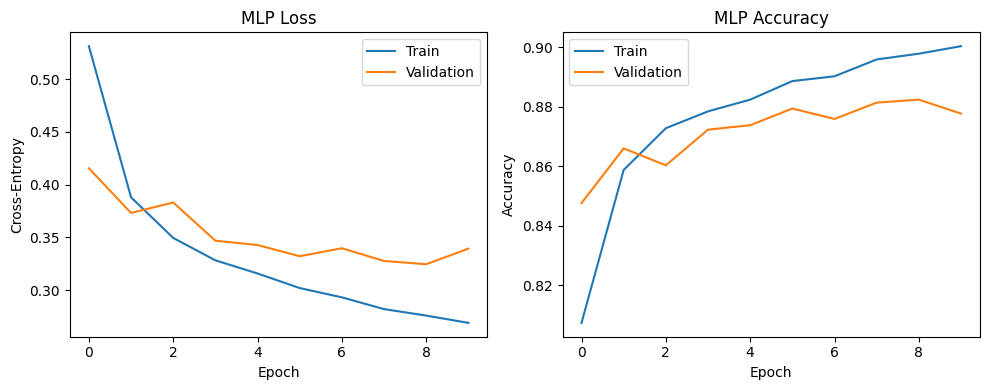

In [ ]:
plt.figure(figsize=(10, 4))  # create a wide figure for placing plots side by side
plt.subplot(1, 2, 1)  # first subplot for loss curves
plt.plot(mlp_history["train_loss"], label="Train")
plt.plot(mlp_history["val_loss"], label="Validation")
plt.title("MLP Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy")
plt.legend()

plt.subplot(1, 2, 2)  # second subplot for accuracy curves
plt.plot(mlp_history["train_acc"], label="Train")
plt.plot(mlp_history["val_acc"], label="Validation")
plt.title("MLP Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()  # reduce whitespace and avoid label overlap
plt.show()  # display the figure


In [ ]:
mlp_test_loss, mlp_test_acc, mlp_confusion = evaluate(mlp, test_loader, mlp_criterion, device)  # final evaluation on hold-out set
print(f"[MLP] Test Loss: {mlp_test_loss:.4f} | Test Accuracy: {mlp_test_acc:.4f}")  # report summary metrics


[MLP] Test Loss: 0.3394 | Test Accuracy: 0.8777


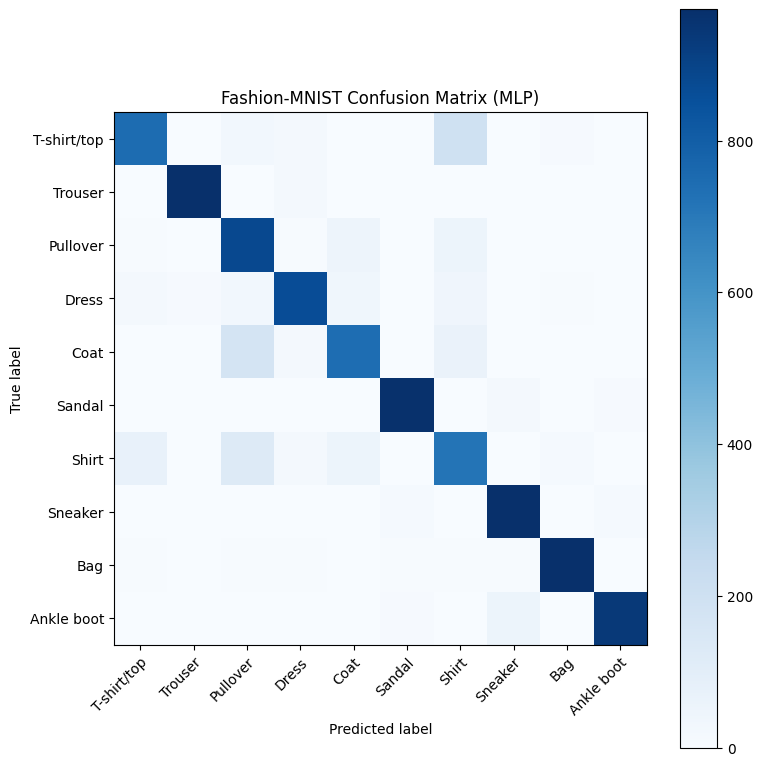

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))  # create figure/axes for confusion matrix heatmap
im = ax.imshow(mlp_confusion, interpolation="nearest", cmap=plt.cm.Blues)  # plot counts as colored grid
ax.figure.colorbar(im, ax=ax)  # add color bar for scale reference
ax.set(
    xticks=range(len(LABEL_NAMES)),
    yticks=range(len(LABEL_NAMES)),
    xticklabels=LABEL_NAMES,
    yticklabels=LABEL_NAMES,
    ylabel="True label",
    xlabel="Predicted label",
    title="Fashion-MNIST Confusion Matrix (MLP)",
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # rotate labels for readability
plt.tight_layout()  # adjust layout so labels fit
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix_mlp.png"))  # persist figure for later review
plt.show()  # display the plot in notebook


## Model Definition

Build the convolutional neural network and set up loss and optimizer components.


In [ ]:
class FashionCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # first conv extracts low-level patterns
            nn.BatchNorm2d(32),  # stabilize activations across batch
            nn.ReLU(inplace=True),  # non-linear activation
            nn.MaxPool2d(2),  # downsample spatial dimensions by factor of 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # deeper conv for richer features
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),  # regularize convolutional features
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),  # flatten feature maps to vector
            nn.Linear(64 * 7 * 7, 128),  # dense layer for representation learning
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # regularize fully connected layers
            nn.Linear(128, 10),  # logits for 10 fashion classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)  # convolutional feature extraction
        x = self.classifier(x)  # classification head
        return x


model = FashionCNN().to(device)  # move model to CPU/GPU
criterion = nn.CrossEntropyLoss()  # suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # optimizer setup
model


FashionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Training and Evaluation Utilities

Create helper functions for one training epoch and validation evaluation with confusion matrix tracking.


In [ ]:
def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
) -> Tuple[float, float]:
    """Run one supervised training epoch and report loss/accuracy."""
    model.train()  # enable training-specific behavior (dropout, batch norm updates)
    running_loss = 0.0  # accumulate loss scaled by batch size
    correct = 0  # count of correctly classified samples
    total = 0  # number of processed samples

    for inputs, targets in dataloader:  # iterate over mini-batches
        inputs, targets = inputs.to(device), targets.to(device)  # move batch to current device
        optimizer.zero_grad()  # clear gradients from previous step
        outputs = model(inputs)  # forward pass to obtain logits
        loss = criterion(outputs, targets)  # compute cross-entropy loss
        loss.backward()  # backpropagate gradients through the network
        optimizer.step()  # update weights using optimizer

        running_loss += loss.item() * inputs.size(0)  # accumulate weighted loss
        correct += (outputs.argmax(dim=1) == targets).sum().item()  # increment correct predictions
        total += targets.size(0)  # track total samples seen

    epoch_loss = running_loss / total  # average loss across dataset
    epoch_acc = correct / total  # accuracy across dataset
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float, torch.Tensor]:
    """Evaluate model performance and build a confusion matrix."""
    model.eval()  # disable dropout and use running stats for batch norm
    running_loss = 0.0
    correct = 0
    total = 0
    confusion = torch.zeros(10, 10, dtype=torch.int64)  # confusion matrix accumulator

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)  # predicted labels
        correct += (preds == targets).sum().item()
        total += targets.size(0)

        for t, p in zip(targets.view(-1), preds.view(-1)):
            confusion[t.long(), p.long()] += 1  # update confusion matrix cell

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, confusion


## Model Training

Run the main training loop, log metrics each epoch, and save the best checkpoint.


In [ ]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}  # metric tracking containers

best_acc = 0.0  # store the best validation accuracy seen so far

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)  # train for one epoch
    val_loss, val_acc, _ = evaluate(model, test_loader, criterion, device)  # evaluate on test split

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_acc:
        best_acc = val_acc  # update best metric
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "fashion_cnn.pt"))  # persist best checkpoint

history  # inspect metrics


Epoch 01/10 | Train Loss: 0.5106 | Train Acc: 0.8174 | Val Loss: 0.3408 | Val Acc: 0.8761
Epoch 02/10 | Train Loss: 0.3540 | Train Acc: 0.8731 | Val Loss: 0.2932 | Val Acc: 0.8943
Epoch 03/10 | Train Loss: 0.3216 | Train Acc: 0.8836 | Val Loss: 0.2744 | Val Acc: 0.8984
Epoch 04/10 | Train Loss: 0.2936 | Train Acc: 0.8934 | Val Loss: 0.2679 | Val Acc: 0.8999
Epoch 05/10 | Train Loss: 0.2745 | Train Acc: 0.9006 | Val Loss: 0.2604 | Val Acc: 0.9037
Epoch 06/10 | Train Loss: 0.2574 | Train Acc: 0.9064 | Val Loss: 0.2406 | Val Acc: 0.9125
Epoch 07/10 | Train Loss: 0.2477 | Train Acc: 0.9091 | Val Loss: 0.2353 | Val Acc: 0.9135
Epoch 08/10 | Train Loss: 0.2391 | Train Acc: 0.9126 | Val Loss: 0.2324 | Val Acc: 0.9148
Epoch 09/10 | Train Loss: 0.2266 | Train Acc: 0.9173 | Val Loss: 0.2350 | Val Acc: 0.9110
Epoch 10/10 | Train Loss: 0.2210 | Train Acc: 0.9191 | Val Loss: 0.2350 | Val Acc: 0.9125


{'train_loss': [0.5105828348954519,
  0.3540005256652832,
  0.32163912638028463,
  0.2936415025075277,
  0.2744925752321879,
  0.25736600881417593,
  0.24773683133125304,
  0.23907275331815084,
  0.22661348655223845,
  0.22103853318691255],
 'train_acc': [0.8174333333333333,
  0.8731333333333333,
  0.8836,
  0.8933666666666666,
  0.9006166666666666,
  0.9063666666666667,
  0.9091166666666667,
  0.9126,
  0.9173,
  0.91905],
 'val_loss': [0.3408222869157791,
  0.29324913642406464,
  0.27437625515460967,
  0.26785425279140473,
  0.26038736538887025,
  0.24064274156093599,
  0.2352801232099533,
  0.23242789690494536,
  0.23499044840335845,
  0.23502567985057832],
 'val_acc': [0.8761,
  0.8943,
  0.8984,
  0.8999,
  0.9037,
  0.9125,
  0.9135,
  0.9148,
  0.911,
  0.9125]}

## Training Curves

Visualize loss and accuracy trends over epochs for both training and validation sets.


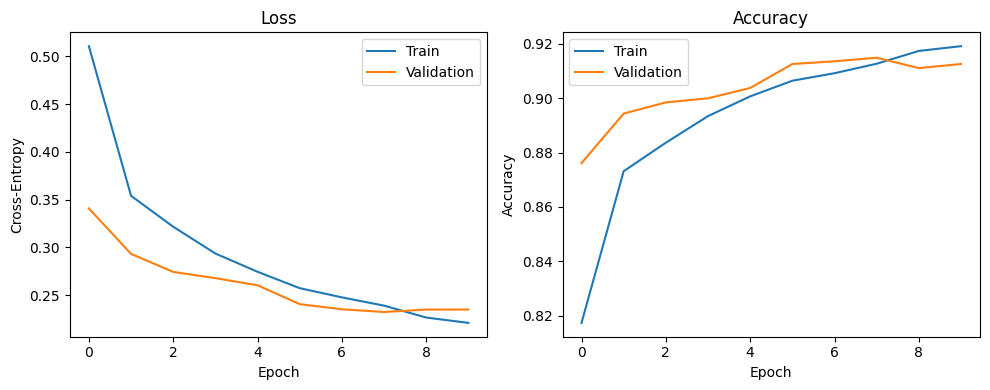

In [ ]:
plt.figure(figsize=(10, 4))  # build figure for side-by-side metrics
plt.subplot(1, 2, 1)  # left subplot plots loss
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy")
plt.legend()

plt.subplot(1, 2, 2)  # right subplot plots accuracy
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()  # manage spacing to prevent overlap
plt.show()  # render the visualization


## Test Evaluation

Report final loss and accuracy on the held-out test set.


In [ ]:
test_loss, test_acc, confusion = evaluate(model, test_loader, criterion, device)  # final evaluation on test split
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")  # concise metric summary


Test Loss: 0.2350 | Test Accuracy: 0.9125


## Summary and Next Steps

**What we accomplished**
- Loaded Fashion-MNIST with normalization and visual sanity checks.
- Trained a baseline MLP and evaluated accuracy, loss curves, and confusion matrix.
- Trained a CNN that improves performance, logging metrics and saving artifacts.
- Inspected confusion matrices and misclassified samples to understand errors.

**Recommended follow-ups**
- Introduce a validation split to tune hyperparameters without touching the test set.
- Experiment with regularization (data augmentation, dropout/batch norm tweaks) to improve generalization.
- Iterate on architectures or learning-rate schedules once the above foundations are in place.


## Confusion Matrix

Plot and save the confusion matrix to inspect per-class performance.


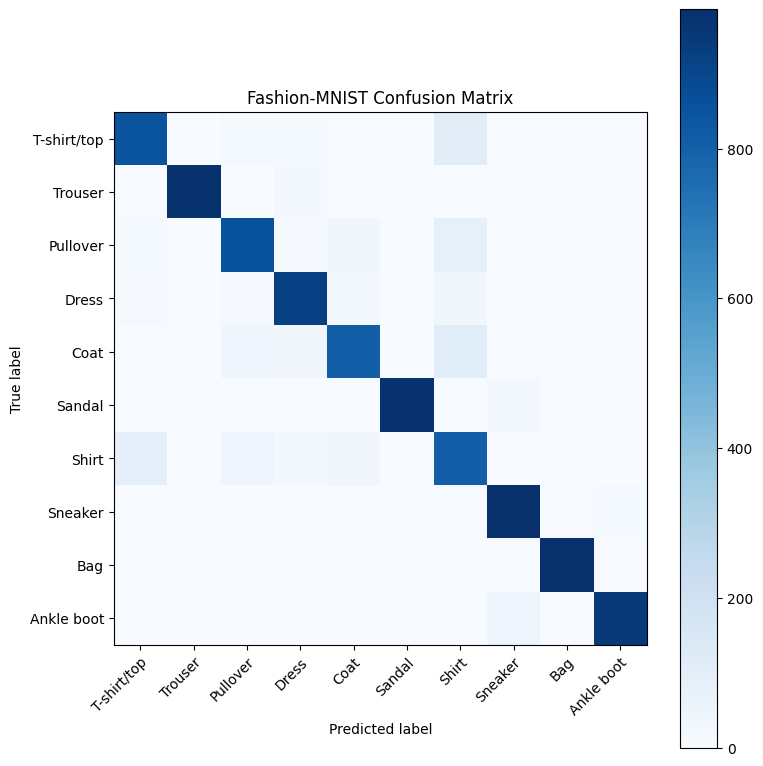

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))  # prepare figure for CNN confusion matrix
im = ax.imshow(confusion, interpolation="nearest", cmap=plt.cm.Blues)  # render confusion matrix values
ax.figure.colorbar(im, ax=ax)  # add color scale legend
ax.set(
    xticks=range(len(LABEL_NAMES)),
    yticks=range(len(LABEL_NAMES)),
    xticklabels=LABEL_NAMES,
    yticklabels=LABEL_NAMES,
    ylabel="True label",
    xlabel="Predicted label",
    title="Fashion-MNIST Confusion Matrix",
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # rotate x labels for readability
plt.tight_layout()  # ensure layout handles long labels
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"))  # save PNG to artifacts folder
plt.show()  # display figure inline


## Misclassified Samples Helper

Define a utility to gather and visualize misclassified examples for qualitative analysis.


In [ ]:
@torch.no_grad()
def show_misclassified(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    max_images: int = 16,
) -> None:
    model.eval()  # inference mode to disable dropout and autograd
    misclassified = []  # store tuples of (image, predicted label, true label)
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)  # predicted class indices
        mismatches = preds != targets  # boolean mask of mistakes
        for img, pred, target in zip(inputs[mismatches], preds[mismatches], targets[mismatches]):
            misclassified.append((img.cpu(), pred.item(), target.item()))  # stash CPU copy for plotting
            if len(misclassified) >= max_images:
                break
        if len(misclassified) >= max_images:
            break

    if not misclassified:
        print("No misclassified samples found.")
        return

    cols = 4
    rows = (len(misclassified) + cols - 1) // cols
    plt.figure(figsize=(2.5 * cols, 2.5 * rows))
    for idx, (img, pred, target) in enumerate(misclassified):
        plt.subplot(rows, cols, idx + 1)  # position subplot
        plt.imshow(img.squeeze(0), cmap="gray")  # show grayscale image
        plt.title(f"P: {LABEL_NAMES[pred]}\nT: {LABEL_NAMES[target]}")  # predicted vs. true label
        plt.axis("off")
    plt.tight_layout()
    plt.show()


## Inspect Misclassifications

Display a grid of incorrect predictions to understand failure cases.


c:\Users\syeda\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


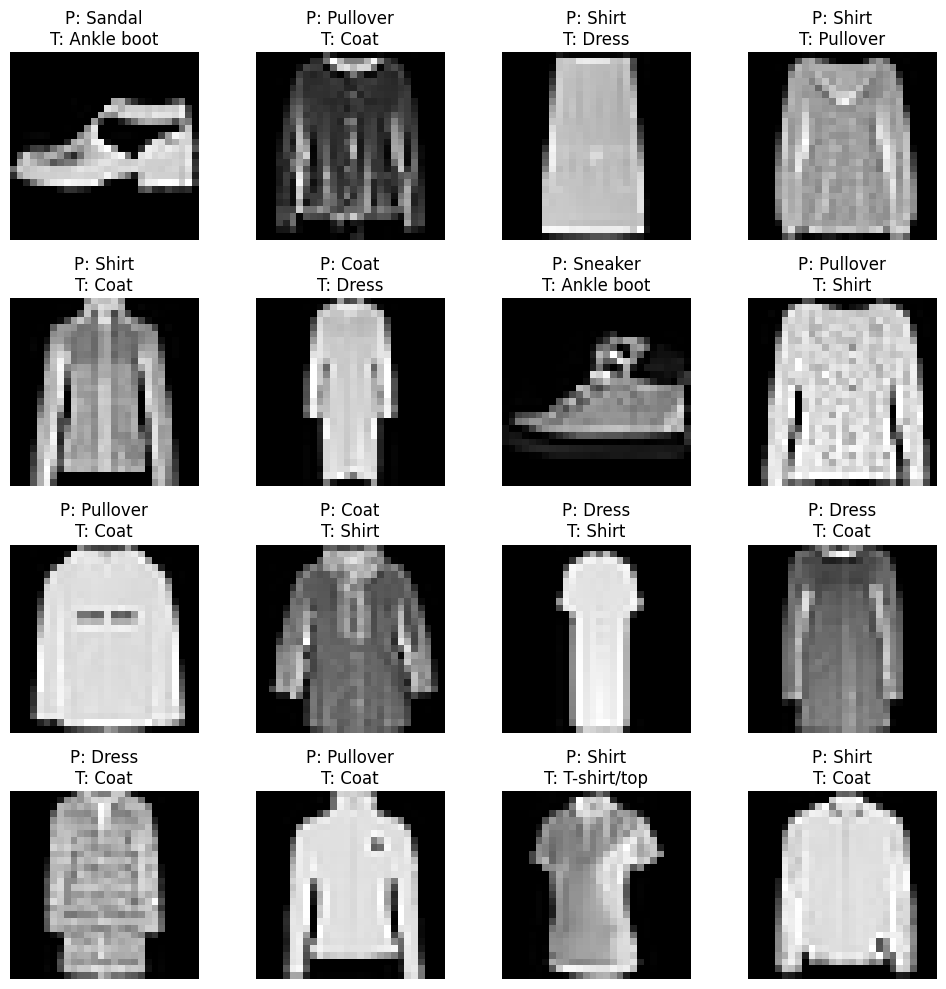

In [ ]:
show_misclassified(model, test_loader, device)  # visualize misclassified samples for qualitative review
